In [1]:
# regular expressions
import re 

# math and data utilities
import numpy as np
import pandas as pd
import scipy.stats as ss
import itertools

# ML and statistics libraries
import scipy.stats as stats
import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set-up default visualization parameters
mpl.rcParams['figure.figsize'] = [10,6]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("Blues_r", 15))

# Exploratory Data Analysis of Home Prices

This notebook will focus primarily on EDA. I'm going to hide most of the code, so that it doesn't detract attention from the analysis. 

Because predicting home prices is a regression problem, I'll be focusing my analysis on the following ideas:
 - __Linearity of Continuous Variables__. If our variables have linear relationships with Sale Price, then when we get new, unseen data on for sale homes, the final sale price will be easier to predict. If our data does not have a linear relationship, then we must either transform the data, or consider non-linear regression models for prediction.
 - __Strength of association.__ Provided that a variable is related to Sale Price, how strong is that relationship? In other words, is a particular variable worth keeping or not? Often this can only be answered by making predictions with AND without the variable in question, then checking the accuracy of the prediction. Our analysis will simply give us an idea of what variables to experiment with.
 - __ANOVA F-Test of categorical variables against sale price.__ Unlike continuous variables, we can not necessarily determine traditional linear relationships between categories and continuous data. For example, we might easily be able to say "The more little Timmy studies (variable X) the better his test scores (variable Y)". However, let's say little Timmy has 3 math books to choose from and must study for an upcoming test. Now, variable X has possible values of book A, book B, or book C, while variable Y is still his test score. Because the books have no underlying rank or order, we cannot give them meaning through numbers. Without order, linear relationships are impossible. Instead we will use the idea of variance of outcome, based on textbook. Through ANOVA, we may look at the outcome of Timmy's test scores after using each of three books. While there may be differences between his test scores, we must dig deep to find out if those differences can really be attributed to his choice of study material. 
 - __Finding and Dealing with Missing Data__ - In this final phase, we will analyze what variables have missing values, why they are missing and how we might deal with the missing data. For example, we will see that the variable __PoolQC__ which describes pool quality and condition has the majority of its entries missing. Should we keep the variable? Perhaps it is missing data, because it is associated with homes that don't have pools. Or should we drop it? Or create a new variable that simply describes "Has Pool" in a yes or no sort of way. 


In [2]:
train_df = pd.read_csv('data/train.csv', index_col='Id')
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Distribution of Target Variable:

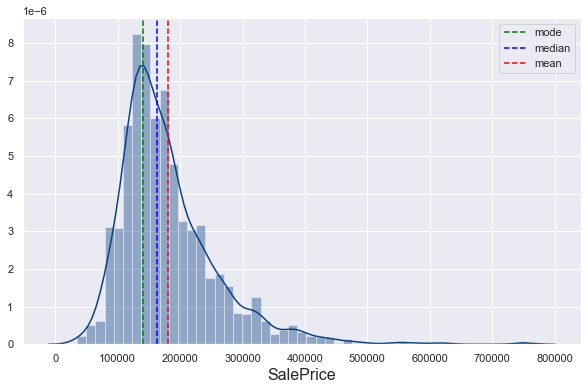

In [3]:
sigma = train_df.SalePrice.std()
mu = train_df.SalePrice.mean()
med = train_df.SalePrice.median()
mode = train_df.SalePrice.mode().to_numpy()

sns.distplot(train_df.SalePrice)
plt.axvline(mode, linestyle='--', color='green', label='mode')
plt.axvline(med, linestyle='--', color='blue', label='median')
plt.axvline(mu, linestyle='--', color='red', label='mean')
plt.legend()

Our response variable appears to be right skewed, so is a candidate for log transformation. Below we see that log(y+1) provides a nice distribution. We will keep this distribution in mind for use in a `TransformedTargetRegressor` when it is time to make predictions.

testing a log transformation supplies a much more normal distribution:

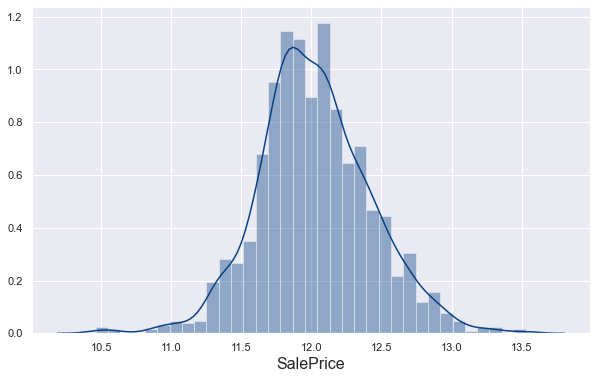

In [4]:
sns.distplot(np.log1p(train_df.SalePrice), kde=True)

Let's get warmed up with a check our intuition that it's not just quantity but quality that counts toward final sale price:

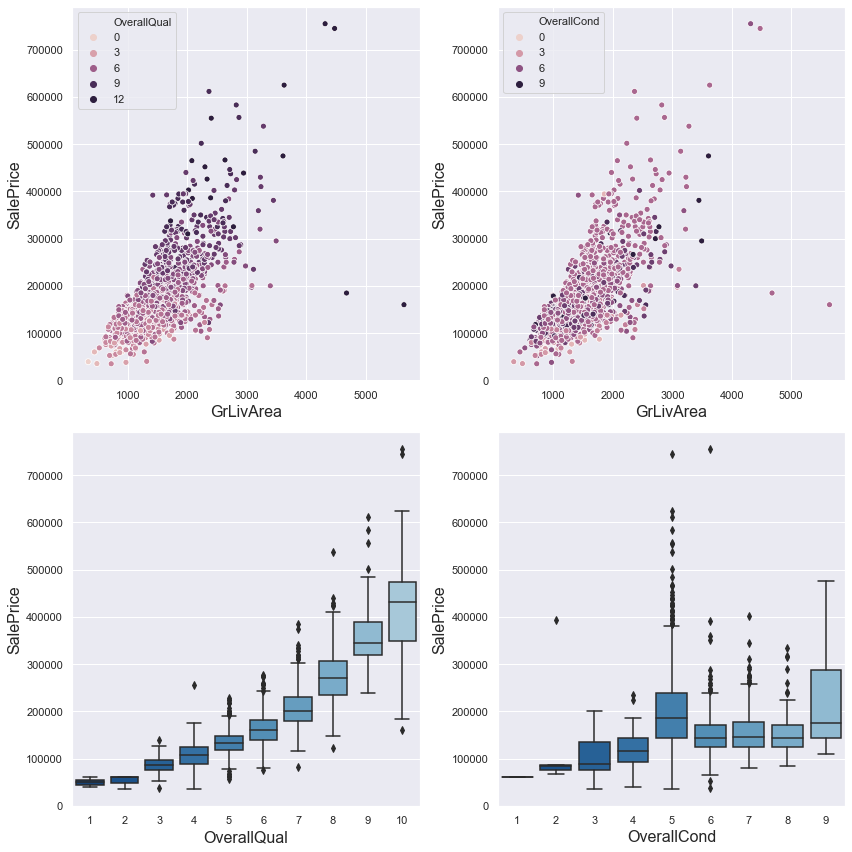

In [5]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallQual', data=train_df, ax=axes[0,0])
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='OverallCond', data=train_df, ax=axes[0,1])
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df, ax=axes[1,0])
sns.boxplot(x='OverallCond', y='SalePrice', data=train_df, ax=axes[1,1])
plt.tight_layout()

It appears that sale price is graduated not only by above ground living area but also by quality of material and finish (described by __OverallQual__). Surprisingly, it appears that overall condition (__OverallCond__) is rather well mixed. The box plots do show negative skew (towards lower price) in below average condition homes and positive skew (towards higher price) in above average condition homes, but nothing to write home about. There are also a large number of outliers in the category 5 (average condition) of __OverallCond__. This may contribute to the disorder.

Also notice the two outliers, homes with relatively large square footage, plus high quality materials, above average condition which sold ___well___ below average. We will likely discount these outliers for purposes of making predictions.

Next we will run through some of the other most intuitive predictors of home sale prices, looking for correlation to our response variable (sale price). We will use both standard univariate correlation now, and later post-hoc residual plots to test our assumptions of linearity. In order to perform statistical modeling, we need to convert our categorical data to numbers first. The variables I believe intuitively add to sale prices are:

In [6]:
# a selection of variables that I expect to add to home value and/or curbside appeal, by variable type
exp_ordinal = ['ExterQual', 'ExterCond', 'Functional', 'OverallQual', 'OverallCond', 'BsmtCond', 'GarageCars']
exp_nominal = ['Neighborhood', 'MSZoning', 'Condition1', 'Condition2', 'GarageCars']
exp_contin  = ['LotArea', 'GrLivArea', 'GarageArea']

Almost all "Quality and Condition" variables share the same letter code scheme in the data: 

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

Some variables like __BsmtCond__ (Basement Condition) have an additional category (NA - No Basement). We will encode these as integers from 0 to 5.

In [7]:
qual_map = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 
             'BsmtCond', 'HeatingQC', 'KitchenQual', 
             'FireplaceQu', 'GarageQual', 'GarageCond',
             'PoolQC']

for col in qual_vars:
    train_df[col] = train_df[col].map(qual_map)
    
train_df[qual_vars]

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
Id,,,,,,,,,,
1,4,3,4.0,3.0,5,4,NaN,3.0,3.0,NaN
2,3,3,4.0,3.0,5,3,3.0,3.0,3.0,NaN
3,4,3,4.0,3.0,5,4,3.0,3.0,3.0,NaN
4,3,3,3.0,4.0,4,4,4.0,3.0,3.0,NaN
5,4,3,4.0,3.0,5,4,3.0,3.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1456,3,3,4.0,3.0,5,3,3.0,3.0,3.0,NaN
1457,3,3,4.0,3.0,3,3,3.0,3.0,3.0,NaN
1458,5,4,3.0,4.0,5,4,4.0,3.0,3.0,NaN


The __Functional__ variable, which outlines major deductions or damage might be good to inspect, so we will encode it as a ordinal variable.

In [8]:
func_map = {
    'Sal':  1,
    'Sev':  2,
    'Maj2': 3,
    'Maj1': 4,
    'Mod':  5,
    'Min2': 6,
    'Min1': 7,
    'Typ':  8
}

train_df['Functional'] = train_df.Functional.map(func_map)

## Looking at Relationships Between Variables:

Now, we must consider the association between our predictor variables and our response variable. Because we are dealing with a continuous response variable, but have some categorical features, we will have to think carefully about how to measure association. For the ordinal data, I propose either using Kendall's $\tau$ or descritizing sale prices and using Goodman and Kruskal's $\gamma$. Since Kendall's $\tau$ is included in the scikit learn library, we need not write our own method. 

### Broad Overview by Heatmap:

First, let's take an high level look of all of our candidate variables' relationships:

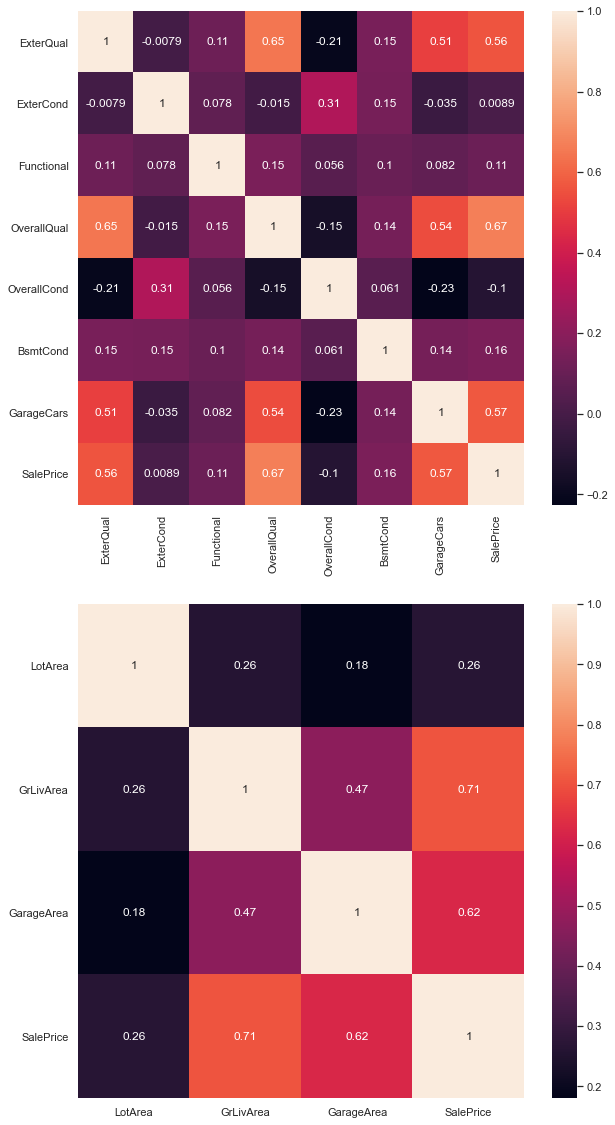

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(10,20))
sns.heatmap(train_df[exp_ordinal+['SalePrice']].corr(method='kendall'), annot=True, ax=axes[0])
sns.heatmap(train_df[exp_contin+['SalePrice']].corr(), annot=True, ax=axes[1])
rot = [ax.set_yticklabels(ax.get_yticklabels(), rotation=0) for ax in axes]

For our continuous and ranked data, we see that most of our assumptions of moderate relationship to sale price held true. The notable exception were the two "Condition" variables. At a uni-variate level, there is little correlation with sale price, and what we do see is negative correlation!

Also interestingly, it appears that Homes on larger lots tend to have smaller garages. 

## Predictor-Outcome Relationships Variable by Variable:

Next, we should look a little deeper by taking a close look at each variable and how it is associated with sale price. We will begin with analyzing our continuous variables (__Definition:__ variables whose values range is continuous rather than discrete).

### Continuous Data:

I chose three continuous variables to analyze. As a non-expert in real estate, I imagined what I would care about most in a home that could be measured on a continuous scale. I chose lot area, garage area, and above ground living area. A did not include finished or unfinished basement area, because I got a hot tip from the best agent I know (shout out to mom!) that often appraisers give it no extra value over a home without a basement. Isn't that crazy?!

In [111]:
def plot_response_corr(df, features, response, corr_type):
    
    cor = pd.DataFrame()
    
    # Measure difference between Spearman's and Pearson's to analyze for non-linearity
    if corr_type == 's-p':
        
        cor['feature'] = features
        cor['spearman'] = [df[f].corr(df[response], 'spearman') for f in features]
        cor['pearson'] = [df[f].corr(df[response], 'pearson') for f in features]
        cor['comparison'] = cor['spearman'] - cor['pearson']
        
        
        fig, axes = plt.subplots(1,3, figsize=(12, 4))
        [ax.tick_params('x', labelrotation=45) for ax in axes]

        sns.barplot(
            data=cor.sort_values(by='comparison'), 
            x='feature', y='comparison', ax=axes[2]
        ).set_title('S-P Comparison')

        sns.barplot(
            data=cor.sort_values('spearman'),
            x='feature', y='spearman', ax=axes[1]
        ).set_title('Spearman Association')

        sns.barplot(
            data=cor.sort_values('pearson'),
            x='feature', y='pearson', ax=axes[0]
        ).set_title('Pearson Correlation')
        
    else:
        cor['feature'] = features
        cor[corr_type] = [df[f].corr(df[response], corr_type) for f in features]
        cor = cor.sort_values(corr_type)
        plt.figure(figsize=(len(features)*1.5, 5))
        axes = sns.barplot(data=cor, x='feature', y=corr_type) \
            .set_title(f'{corr_type} Association to Response Variable')        
    
    
    plt.tight_layout()
    plt.show()

    return cor 

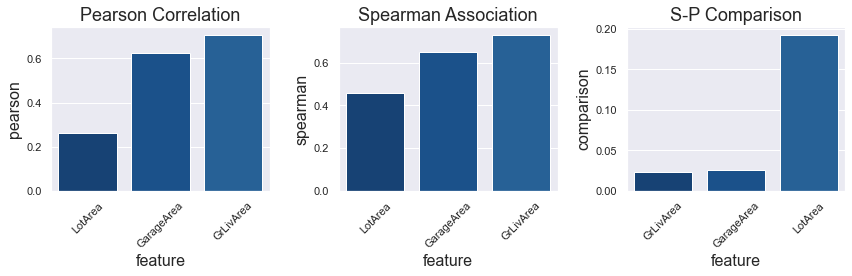

In [114]:
df = plot_response_corr(train_df, exp_contin, 'SalePrice', 's-p')

The above measures of correlation between continuous variables indicate moderate to very high association to the sale price. 

Interestingly the difference between Spearman's measure and Pearson's measure for the variable __LotArea__ indicate that there is an monotonically increasing, non-linear association with living area square footage and sale price. It would be interesting to know more about the nature of this relationship. Is it exponential? Logarithmic?  

### Ordinal Categories:

Next we will look at the same measures of association for our ordinal variables (__definition:__ variables whose values are limited and discrete, but that have some underlying order or rank. Think mild, moderate, severe for a disease).

We will also include __Kendall's Tau ($\tau$)__, which is typically more robust against outliers in the data. It will therefore give a more conservative estimate of correlation. 

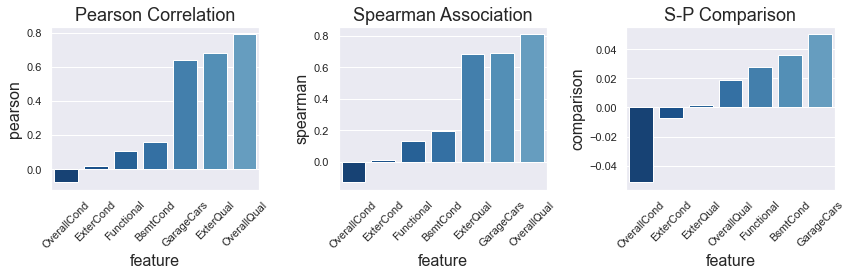

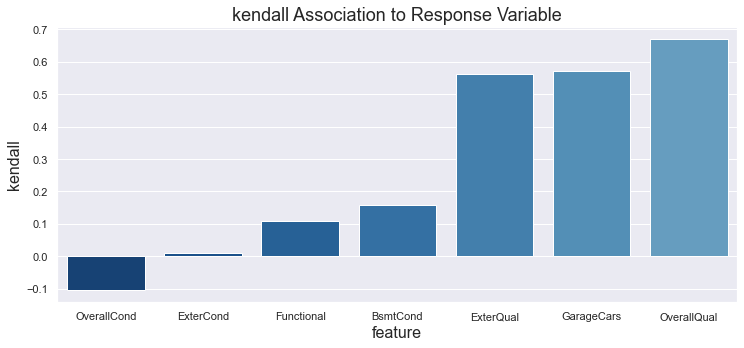

In [113]:
df1 = plot_response_corr(train_df, exp_ordinal, 'SalePrice', 's-p')
df2 = plot_response_corr(train_df, exp_ordinal, 'SalePrice', 'kendall')

### Categorical Data (Nominal)

For our nominal data, quantitative association is somewhat difficult to achieve in the same way as ordinal and continuous data. We can, however take a look at box our violin plots for each of our interesting nominal variables. The idea is to look for separation of home values according to category. We are graphically answering questions like _"Is the average cost of a home significantly different between neighborhoods X, Y, and Z?"_.

To refresh our memories on what our nominal variables are:

- __Neighborhood__
- __MSZoning__
- __Condition1 & Condition2__


### Neighborhood:

I have created a boxplot of neighborhoods ordered by there average home value. Visually, we do see a rough ordering to these neighborhoods. Is this variance in sale price due to differences between neighborhoods, or is it more due to differences within individual neighborhoods (for example, is the mean home value of neigborhood X quite high compared to neighborhood Y because there is a billion dollar mansion at the end of the street, while all the other homes are relatively cheap?). This question cannot be well answered by a graph, and we will address it later. 

In [13]:
# for ordering the boxplots by median
grouped = train_df.loc[:,['Neighborhood', 'SalePrice']] \
    .groupby(['Neighborhood']) \
    .mean() \
    .sort_values(by='SalePrice')

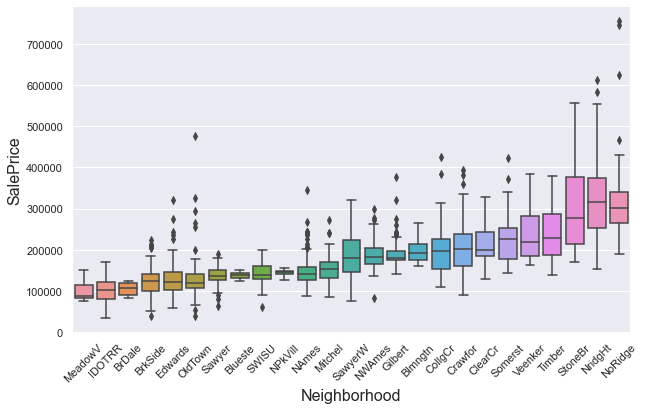

In [14]:
chart = sns.boxplot(x=train_df.Neighborhood, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

We will perform one way ANOVA on the data to see if this difference between neighborhoods is significant (statistically). It remains to be seen how much weight the adage "location, location, location" carries.

### Zoning

Our data dictionary defines __MSZoning__ as _"Identifies the general zoning classification of the sale."_, with the following possible categories:

       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

We will apply the same techniques as before to see if we can rank these zones by their average home value.

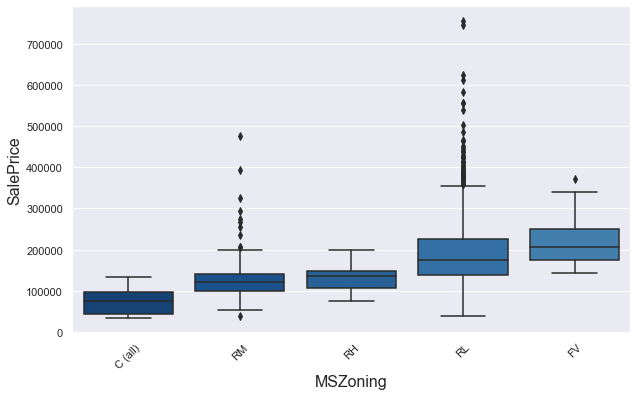

In [15]:
grouped = train_df.loc[:,['MSZoning', 'SalePrice']] \
    .groupby(['MSZoning']) \
    .mean() \
    .sort_values(by='SalePrice')

chart = sns.boxplot(x=train_df.MSZoning, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

As before, there is visually some separation between the means. We will add it to the 'to-do ANOVA' list.

## Proximity to Urban Features

The __Condition1 & Condition2__ variables describe proximity to the following features such as parks, railroads, etc:

       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

We will see if we can rank these features as before, but this time we will rank both individual features and every combination of two. 

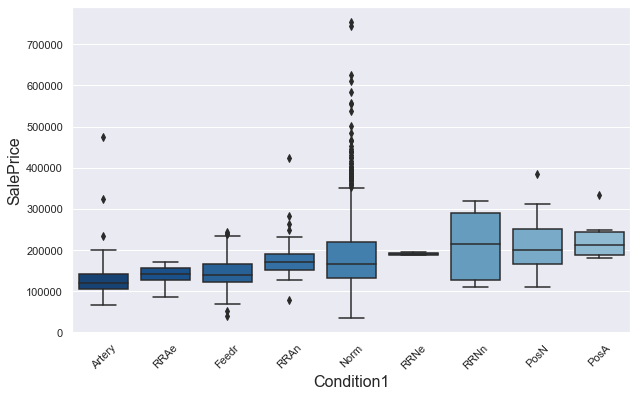

In [16]:
grouped = train_df.loc[:,['Condition1', 'SalePrice']] \
    .groupby(['Condition1']) \
    .mean() \
    .sort_values(by='SalePrice')

chart = sns.boxplot(x=train_df.Condition1, y=train_df.SalePrice, order=grouped.index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

This one doesn't look as promising to me. Again, only a test will tell. Let's go ahead and run such a test on all of these questionable categories. While we have already seen clear association between ordinal variables and __SalePrice__ we will include them in this analysis as well. 

### Performing Analysis of Variation (ANOVA)

In [102]:
def anova(df, predictor, target, alpha=0.05):
    
    # get unique, indendant treatments (categories in predictory)
    treatments = df.loc[df[predictor].notnull(), predictor].unique()
    group_values = []
    
    # group target variable by category
    for t in treatments:
        group_values.append(df.loc[df[predictor] == t, target].to_numpy())
    
    # calculate degrees of freedom and confidence level
    k = len(treatments)
    n = df[predictor].notnull().sum()
    conf = 1 - alpha
    df1 = k - 1
    df2 = n - k
    
    # calculate critical value of F-distribution
    crit_val = stats.f.ppf(conf, df1, df2)
    
    # calculate F and p-values
    f, p = stats.f_oneway(*group_values)
    
    return f, p, crit_val

<function matplotlib.pyplot.show(*args, **kw)>

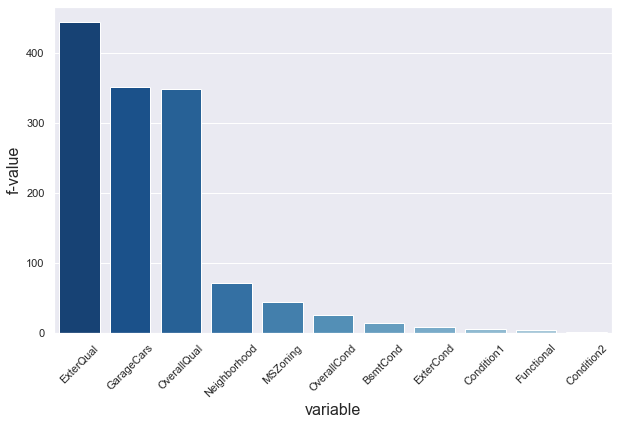

In [115]:
# DataFrame to hold ANOVA results.
f_frame = pd.DataFrame(columns=['variable','p-value','f-value', 'critical'])

# Perform ANOVA on each variable. Store data for plotting
for var in exp_nominal+exp_ordinal:
    f, p, c = anova(train_df, var, 'SalePrice')
    f_frame.loc[len(f_frame)] = [var, p, f, c]

# Plot test results
f_frame.sort_values(by='f-value', ascending=False, inplace=True)
sns.barplot(x='variable', y='f-value', data=f_frame)
plt.xticks(rotation=45)
plt.show

### Summary of ANOVA

What is difficult to see in the visualization is that almost all of our variables passed their F-Test with flying colors. This signifies that there is significant variation in sale price by category within each variable. There are two exceptions to this, one of which is __Condition2__ which describes property proximity to an urban feature (perhaps desirable or not). This is the second of two such variables, meaning it is likely that there is more information, and therefore more variance contained in the first variable. The two graphs of their values shows this to be true:

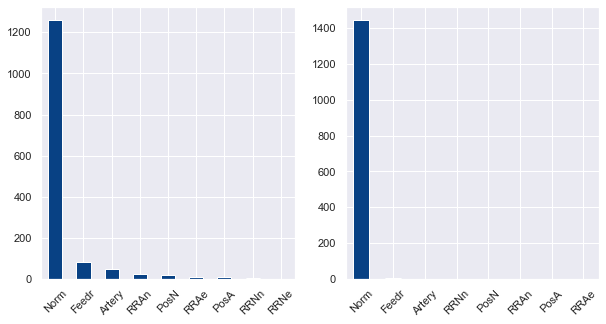

In [19]:
fib, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
train_df['Condition1'].value_counts().plot(kind='bar', ax=ax1, rot=45)
train_df['Condition2'].value_counts().plot(kind='bar', ax=ax2, rot=45)

It does appear that __Condition1__ holds more data than __Condition2__.

## Summary of Visualizations:

The above is a lot to look at. Maybe I should intersperse the breakdown with the graphs. I welcome feedback here. For now, I will break down the graphs in two parts: continuous and categorical.

### Continuous Data

There is moderate to high correlation between sale price and the features describing lot size, above ground living area and garage size. Additionally, while the association appears to be linear in above grade living area and garage area. However, there is some indication of a non-linear relationship between lot area and sale price. It might be worth investigating, and is an indicator that the data needs to be transformed before applying machine learning. 

### Categorical Data (Ordinal)

Most of our intuitions proved to be at least somewhat correct. 

A couple notable exceptions are the low association between __SalePrice__ and __ExterCond__, which was unexpected.

Additionally, there is an inverse association with __OverallCond__. This seems to indicate that better overall condition of a home negatively impacts sale price. In my mind, there are a couple possible explanations:
- First, perhaps the variable is encoded such that higher numbers mean worse condition. (On looking at the encoding, this is not the case
- Second, correlation/association at a univariate level is not necessarily an indicator of association when there are more variables or higher dimensions to the data. With almost 80 variables at play, this is a possibility. 

### Categorical Data (Nominal)

Again, almost all of our assumptions checked out statistically. It appears to me that the variables we covered impact final sale price of homes in Ames, Iowa.

### Checking For Missing Data

Our next round of analysis will focus on missing data. 

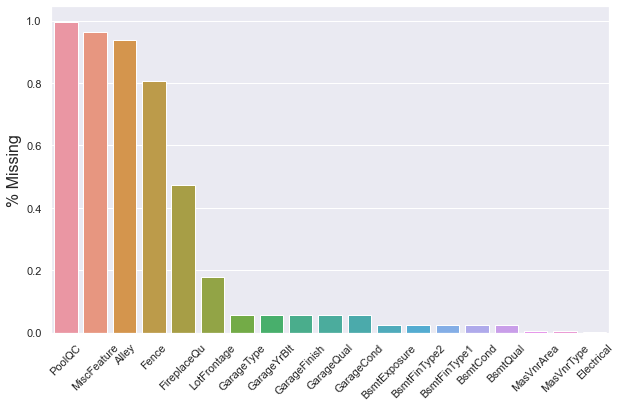

In [107]:
missing = pd.DataFrame({
    'Missing':train_df.isnull().sum(),
    '% Missing': train_df.isnull().sum()/len(train_df)
})
missing = missing[missing['% Missing'] > 0].sort_values(by='Missing', ascending=False)
sns.barplot(x=missing.index, y='% Missing', data=missing)
plt.xticks(rotation=45)
plt.show()

__FireplaceQu__ (Fireplace Quality) is the first variable with less than 50 percent missing data. The __Fireplaces__ (# of fireplaces variable)  has a possible value of "NA - No Fireplace". Perhaps these entries are associated with the missing data in the quality description.

In [108]:
nofire_na = train_df.loc[train_df.FireplaceQu.isna() &
                         (train_df.Fireplaces == 0)].shape[0]

In [109]:
train_df.FireplaceQu.isna().sum(), nofire_na

(690, 690)

So indeed, all 690 instances of missing data in __FireplaceQu__ are associated with homes that don't have fireplaces. According to the variable description, these values should be "NA" not "NaN". We will fix that now:

In [112]:
train_df.loc[train_df.FireplaceQu.isnull(), 'FireplaceQu'] = 'NA'

In [113]:
(train_df.isnull().sum()/train_df.shape[0]).sort_values(ascending=False).head(10)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
LotFrontage     0.177397
GarageType      0.055479
GarageQual      0.055479
GarageCond      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
dtype: float64

Next, we will encode the nominal variables we wish to inspect:

In [114]:
train_df[exp_nominal]

,Neighborhood,MSZoning,Condition1,Condition2,GarageCars
Id,,,,,
1,CollgCr,RL,Norm,Norm,2
2,Veenker,RL,Feedr,Norm,2
3,CollgCr,RL,Norm,Norm,2
4,Crawfor,RL,Norm,Norm,3
5,NoRidge,RL,Norm,Norm,3
...,...,...,...,...,...
1456,Gilbert,RL,Norm,Norm,2
1457,NWAmes,RL,Norm,Norm,2
1458,Crawfor,RL,Norm,Norm,1


In [115]:
# for var in exp_nominal:
#     train_df[var], _ = pd.factorize(train_df[var])